# TODO: Applying the end-to-end ML steps to a different dataset.

In [42]:
import sys
assert sys.version_info >= (3, 5) # python>=3.5
import sklearn
assert sklearn.__version__ >= "0.20" # sklearn >= 0.20

import numpy as np #numerical package in python
import os
%matplotlib inline
import matplotlib.pyplot as plt #plotting package
import pandas as pd

# to make this notebook's output identical at every run
np.random.seed(42)

#matplotlib magic for inline figures
%matplotlib inline 
import matplotlib # plotting library
import matplotlib.pyplot as plt

# Where to save the figures
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split


We will apply what we've learnt to another dataset (airbnb dataset). We will predict airbnb price based on other features.

# [25 pts] Visualizing Data 


### [5 pts] Load the data + statistics

- load the dataset (datasets/airbnb/AB_NYC_2019.csv)
- display the first 3 rows of the data
- drop the following columns: name, host_name, last_review
- display a summary of the statistics of the loaded data and determine which columns have missing values
- plot histograms for 3 features of your choice

In [43]:
airbnb = pd.read_csv('datasets/airbnb/AB_NYC_2019.csv') # load dataset
airbnb.head(3) # display first three rows

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [44]:
airbnb = airbnb.drop("name", axis=1) # drop name
airbnb = airbnb.drop("host_name", axis=1) # drop host_name
airbnb = airbnb.drop("last_review", axis=1) # drop last_review

In [45]:
airbnb.describe() # summary of statistics


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [46]:
# rows where we have null values (col is reviews_per_month)
airbnb_incomplete = airbnb[airbnb.isnull().any(axis=1)].head()
airbnb_incomplete

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
19,7750,17985,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,2,249
26,8700,26394,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,1,0
36,11452,7355,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,1,365
38,11943,45445,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,1,365


<AxesSubplot:>

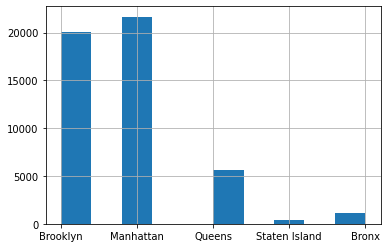

In [47]:
airbnb["neighbourhood_group"].hist() # histogram for neighbourhood group

<AxesSubplot:>

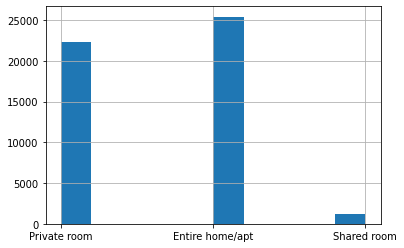

In [48]:
airbnb["room_type"].hist() # histogram for room type

<AxesSubplot:>

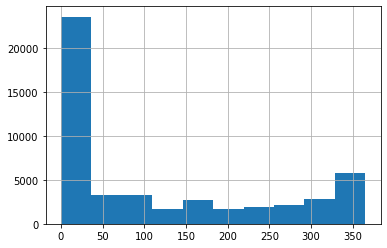

In [49]:
airbnb["availability_365"].hist() # histogram for availability

### [5 pts] Plot total number of reviews per neighbourhood_group

<AxesSubplot:xlabel='Neighbourhood Group', ylabel='Reviews'>

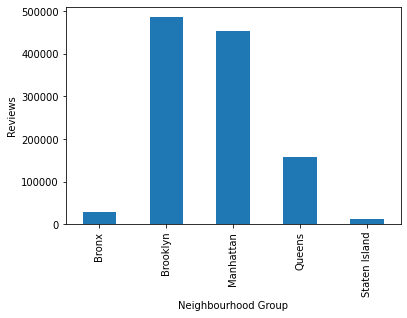

In [50]:
# summing review count over neighbourhood group
reviews_per_group = airbnb.groupby(["neighbourhood_group"]).number_of_reviews.sum().reset_index()
reviews_per_group.plot(kind="bar", x="neighbourhood_group",
                    y="number_of_reviews", xlabel="Neighbourhood Group", 
                    ylabel="Reviews", legend=False)

### [5 pts] Plot map of airbnbs throughout New York (if it gets too crowded take a subset of the data, and try to make it look nice if you can :) ). 
If you overlay the given newyork.png image, you can use parameter extent=[-74.258, -73.7, 40.49, 40.92] with imshow() function.

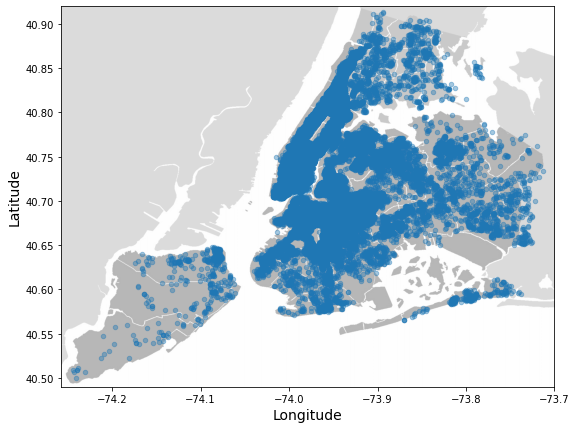

In [51]:
# load image of New York
images_path = os.path.join('./', "images")
os.makedirs(images_path, exist_ok=True)
filename = "newyork.png"

ax = airbnb.plot(kind="scatter", x="longitude", 
                y="latitude", figsize=(10, 7), alpha=0.4)
# overlay the map on the plotted scatter plot
# note: plt.imshow still refers to the most recent figure
# that hasn't been plotted yet.
newyork_img = mpimg.imread(os.path.join(images_path, filename))
plt.imshow(newyork_img, extent=[-74.258, -73.7, 40.49, 40.92], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.show()


### [5 pts] Plot median availability of hosts (host_id) who have more than 50 listings. 

<AxesSubplot:xlabel='Host Id', ylabel='Median Avilability'>

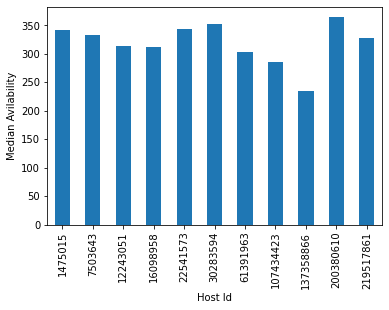

In [52]:
host_50 = airbnb[airbnb["calculated_host_listings_count"] > 50]
host_50_median = host_50.groupby(by="host_id")["availability_365"].median().reset_index()
host_50_median.plot(kind="bar", x="host_id", y="availability_365", 
                xlabel="Host Id", ylabel="Median Avilability", legend=False)

### [5 pts] Plot correlation matrix
- which features have positive correlation?
- which features have negative correlation?

Negative Correlation: price and number_of_reviews, minimum_nights and number_of_reviews, number_of_reviews and calculated_host_listings_count
Positive Correlation: price and minimum_nights, price and calculated_host_listings_count, minimum_nights and calculated_host_listings_count

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='minimum_nights', ylabel='price'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='price'>,
        <AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='minimum_nights'>,
        <AxesSubplot:xlabel='minimum_nights', ylabel='minimum_nights'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='minimum_nights'>,
        <AxesSubplot:xlabel='calculated_host_listings_count', ylabel='minimum_nights'>],
       [<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>,
        <AxesSubplot:xlabel='minimum_nights', ylabel='number_of_reviews'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='number_of_reviews'>,
        <AxesSubplot:xlabel='calculated_host_listings_count', ylabel='number_of_reviews'>],
       [<AxesSubplot:xlabel='price', ylabel='calculated_host_listings_count'>,
        <AxesSubplot:xlabel='minimum_nights', yl

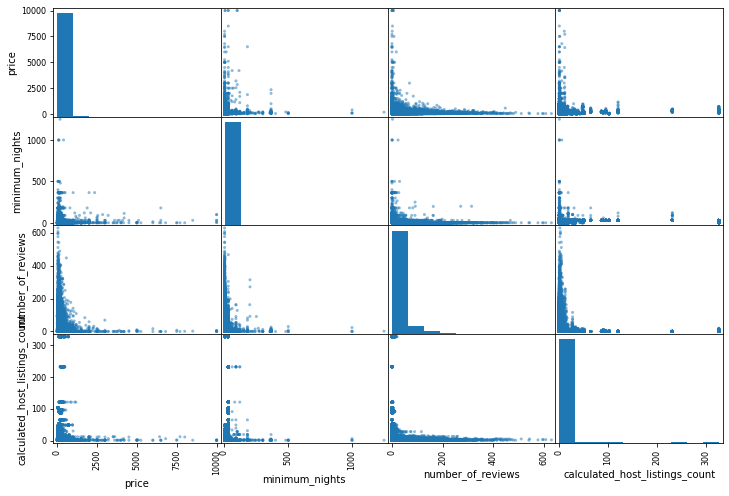

In [53]:
ab_corr_matrix = airbnb.corr()
ab_corr_matrix

ab_attributes = ["price", "minimum_nights", 
    "number_of_reviews", "calculated_host_listings_count"]
scatter_matrix(airbnb[ab_attributes], figsize=(12, 8))

# [25 pts] Prepare the Data

### [5 pts] Set aside 30% of the data as test set (70% train, 30% test).

In [54]:
# splitting data
ab_train_set, ab_test_set = train_test_split(airbnb, test_size=0.3, random_state=42)
# dropping columns I don't feel are necessary
ab_test_set.drop("host_id", axis=1)
ab_train_set.drop("host_id", axis=1)


,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
21681,17418006,Queens,Cambria Heights,40.69206,-73.74546,Entire home/apt,169,2,65,2.33,1,263
26482,21079975,Brooklyn,Sunset Park,40.66060,-73.99455,Entire home/apt,94,2,24,1.15,1,12
20859,16519069,Manhattan,Kips Bay,40.74227,-73.97432,Private room,100,5,2,0.07,1,0
45464,34773215,Brooklyn,Bedford-Stuyvesant,40.68676,-73.94593,Private room,51,1,4,2.86,3,0
22583,18269285,Manhattan,Midtown,40.76013,-73.96566,Shared room,99,3,6,0.24,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,8754339,Manhattan,Washington Heights,40.84650,-73.94319,Shared room,60,1,0,NaN,1,0
44732,34383329,Manhattan,Chelsea,40.73957,-74.00082,Private room,85,2,4,1.90,1,76
38158,30109697,Manhattan,Upper West Side,40.78318,-73.97372,Entire home/apt,130,30,1,0.34,5,261
860,304799,Manhattan,Upper West Side,40.77508,-73.97990,Entire home/apt,150,2,11,0.13,1,2


### [5 pts] Augment the dataframe with two other features which you think would be useful

In [55]:
ab_train_set["availabiliy_vs_min_nights"] = ab_train_set["availability_365"]/ab_train_set["minimum_nights"]
ab_train_set["reviews_vs_listing"] = ab_train_set["number_of_reviews"]/ab_train_set["calculated_host_listings_count"]

ab_test_set["availabiliy_vs_min_nights"] = ab_test_set["availability_365"]/ab_test_set["minimum_nights"]
ab_test_set["reviews_vs_listing"] = ab_test_set["number_of_reviews"]/ab_test_set["calculated_host_listings_count"]

### [5 pts] Impute any missing feature with a method of your choice, and briefly discuss why you chose this imputation method

In [56]:
ab_train_set.drop("reviews_per_month", axis=1)
ab_test_set.drop("reviews_per_month", axis=1)

# I chose to drop the missing feature because I felt that it wasn't necessary
# to include, considering we have the total number of reviews

# Remove target label from training set (i.e. don't use it as a feature)
ab_features_train = ab_train_set.drop("price", axis=1)
# Extract target labels into a separate list
ab_targets_train = ab_train_set["price"].tolist()

# Same for test data:
ab_features_test = ab_test_set.drop("price", axis=1)
ab_targets_test = ab_test_set["price"].tolist()


### [10 pts] Code complete data pipeline using sklearn mixins

In [57]:
class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    ["availabiliy_vs_min_nights"] = ["availability_365"]/["minimum_nights"]
    ["reviews_vs_listing"] = ["number_of_reviews"]/["calculated_host_listings_count"]
    '''
    # column index
    min_nights_ix, reviews_ix, listings_ix, availability_ix = 3, 4, 6, 7
    # min_nights_ix, reviews_ix, listings_ix, availability_ix = 4, 5, 7, 8
    
    def __init__(self): 
        pass
    def fit(self, X, y=None):
        # This function could be used to learn something about the training data, e.g.
        # what are the statistics of the data. For example, if transform() function
        # is used to standardize the data, fit() function can find the mean/std of the 
        # training data. In this example, transform() function does not need to know
        # anything about our training data, so this function is not needed.
        return self
    def transform(self, X):
        # Add three new columns to our dataset:
        availabiliy_vs_min_nights = X[:, self.availability_ix] / X[:, self.min_nights_ix]
        reviews_vs_listing = X[:, self.reviews_ix] / X[:, self.listings_ix]
        return np.c_[X, availabiliy_vs_min_nights, reviews_vs_listing]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])

# Transform categorical/numerical columns using different approaches:
categorical_features = ["neighbourhood_group", "neighbourhood", "room_type"]
numerical_features = [x for x in ab_features_train.columns if x not in categorical_features]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        # TODO idk if this is the right way to go about it
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

ab_features_train_transformed = full_pipeline.fit_transform(ab_features_train)

# [15 pts] Fit a model of your choice

The task is to predict the price, you could refer to the housing example on how to train and evaluate your model using Root Mean Squared Error (RMSE).
Provide both train and test set RMSE values. Also, plot the predictions against the actual values.

In [58]:
# train a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(ab_features_train_transformed, ab_targets_train)

# choose a few training examples and make predictions on them
features = ab_features_train_transformed[:5, :]
targets = ab_targets_train[:5]
predictions = lin_reg.predict(features)
all_predictions = lin_reg.predict(ab_features_train_transformed)

rmse = mean_squared_error(ab_targets_train, all_predictions, squared=False)
print("Root Mean Squared Error:", rmse)

print("Predictions:", predictions)
print("Actual labels:", list(targets))

Root Mean Squared Error: 240.8604324306705
Predictions: [181.43637472 152.9449601  113.15862946  59.70053726 140.8478168 ]
Actual labels: [169, 94, 100, 51, 99]


In [59]:
# Transform test set using our pipeline
ab_features_test_transformed = full_pipeline.transform(ab_features_test)

# Make predictions on transformed data set
ab_predictions_test = lin_reg.predict(ab_features_test_transformed)

# Evaluate predictions
rmse = mean_squared_error(ab_targets_test, ab_predictions_test, squared=False)
print("Root Mean Squared Error:", rmse)

# Show a few predictions and corresponding labels
print("Sample predictions:", ab_predictions_test[:5])
print("Sample labels:", ab_targets_test[:5])

Root Mean Squared Error: 184.91353830047194
Sample predictions: [149.94828015  40.89827492 121.25452776 251.68695259 173.17605218]
Sample labels: [89, 30, 120, 470, 199]


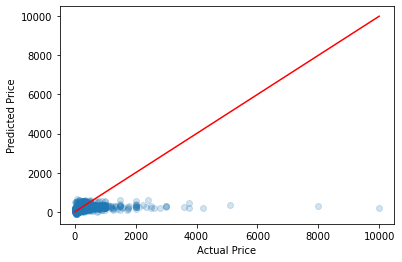

In [60]:
# We can also visualize our predicted values against the correct values. Ideally, our
# predictions should be very close to the correct value, i.e. the predictions should be
# close to the red line.

plt.scatter(ab_targets_test, ab_predictions_test, alpha=0.2)
plt.plot([0,10000],[0,10000], 'r') # Draw a red line between points (0,0) and (500000,500000)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()